In [126]:
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
import xarray as xr
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from IPython.display import Image, display
from sklearn.metrics import mean_squared_error
import numpy as np

In [21]:
pio.renderers.default="notebook"

In [22]:
df = pd.read_csv('./data/df_final_merged.csv')

In [23]:
df['time'] = pd.to_datetime(df['time'], format='mixed', errors='coerce')
df = df.sort_values("time")

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 291966 entries, 0 to 291965
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   time                       291966 non-null  datetime64[ns, UTC]
 1   index                      291966 non-null  int64              
 2   symbol                     291966 non-null  object             
 3   price                      291966 non-null  float64            
 4   quantity                   291966 non-null  float64            
 5   is_market_maker            291966 non-null  object             
 6   bid_price_spot             291966 non-null  float64            
 7   ask_price_spot             291966 non-null  float64            
 8   mid_price_spot             291966 non-null  float64            
 9   price_dev                  291966 non-null  float64            
 10  trade_direction            291966 non-null  int64            

In [26]:
df.timedelta_ms

0            NaN
1          141.0
2         1301.0
3          666.0
4         1735.0
           ...  
291961    1308.0
291962       0.0
291964       0.0
291963     797.0
291965    3282.0
Name: timedelta_ms, Length: 291966, dtype: float64

### Sudden Price Flag

In [84]:
df['spot_sudden_flag'] = (
    (df['window_5_pct_change'] < -0.00651) |
    (df['window_5_pct_change'] > -0.00485)
).astype(int)

df['perp_sudden_flag'] = (
    (df['window_3_pct_change_perp'] < -0.001) |
    (df['window_3_pct_change_perp'] > 0.247)
).astype(int)

### Predicting Perpetual Based on Spot

In [213]:
features = [
    'spot_sudden_flag',
    'timedelta_ms',
    'mid_price_spot',
    'price_dev',
    'rolling_signed_volume_3ms',
    'rolling_signed_volume_5ms',
    'trade_direction'
]
target = 'window_3_pct_change_perp'

# Drop rows with missing values
df_model = df[features + [target]].dropna().reset_index(drop=True)

# Scale features
scaler = StandardScaler()
X_data = scaler.fit_transform(df_model[features].values)
y_data = df_model[target].values

In [214]:
with pm.Model() as model_5ms_t:
    # priors
    a = pm.Normal('a', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=X_data.shape[1])
    sigma = pm.HalfNormal('sigma', 1)

    # v_ = pm.Exponential("v_", 1/29) 
    # v = pm.Deterministic("v", v_+1) # weakly informative prior

    # linear model
    u = pm.Deterministic('mu', a+pm.math.dot(X_data, beta))

    # likelihood
    # y_pred = pm.StudentT('y', mu=u, sigma=sigma, nu=v, observed=y_data)
    y_pred = pm.Normal('y', mu=u, sigma=sigma, observed=y_data)

    # inference
    idata_5ms_t = pm.sample(idata_kwargs={'log_likelihood':True})
    idata_5ms_t.extend(pm.sample_posterior_predictive(idata_5ms_t))

Initializing NUTS using jitter+adapt_diag...
INFO	pymc.sampling.mcmc:mcmc.py:init_nuts()- Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO	pymc.sampling.mcmc:mcmc.py:sample()- Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, beta, sigma]
INFO	pymc.sampling.mcmc:mcmc.py:_print_step_hierarchy()- NUTS: [a, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
INFO	pymc.sampling.mcmc:mcmc.py:_sample_return()- Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
Sampling: [y]
INFO	pymc.sampling.forward:forward.py:sample_posterior_predictive()- Sampling: [y]


Output()

In [215]:
az.summary(idata_5ms_t, var_names=["a", "beta", "sigma"], hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.001,0.001,-0.000,0.002,0.0,0.0,6464.0,2746.0,1.0
beta[0],-0.002,0.001,-0.003,-0.001,0.0,0.0,8000.0,2818.0,1.0
beta[1],-0.001,0.001,-0.002,0.000,0.0,0.0,5928.0,2924.0,1.0
beta[2],-0.004,0.001,-0.005,-0.003,0.0,0.0,7727.0,2666.0,1.0
beta[3],-0.014,0.001,-0.015,-0.012,0.0,0.0,5999.0,3105.0,1.0
beta[4],-0.016,0.001,-0.018,-0.014,0.0,0.0,4695.0,3373.0,1.0
beta[5],-0.002,0.001,-0.004,0.000,0.0,0.0,4568.0,3393.0,1.0
beta[6],0.021,0.001,0.020,0.022,0.0,0.0,5809.0,3378.0,1.0
sigma,0.128,0.000,0.127,0.129,0.0,0.0,7688.0,3150.0,1.0


In [216]:
mu_mean = idata_5ms_t.posterior["mu"].mean(dim=("mu_dim_0"))  # shape: [chain, draw]
idata_5ms_t.posterior['posterior_mean'] = mu_mean

[]

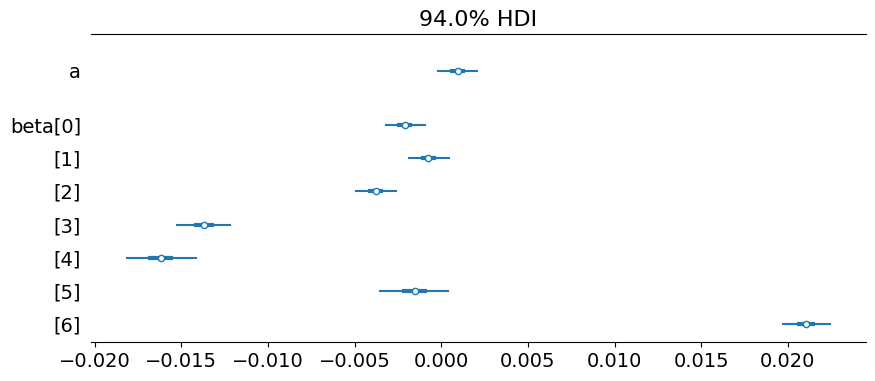

In [217]:
az.plot_forest(idata_5ms_t, var_names=['a', 'beta'], combined=True, figsize=(10,4))
plt.plot()

In [223]:
spot_population_mean_5pct_change = np.mean(df['window_3_pct_change_perp']) * 100
print(f"Mean percentage change of spot population: {spot_population_mean_5pct_change:.8f}%")

Mean percentage change of spot population: 0.09564078%


[]

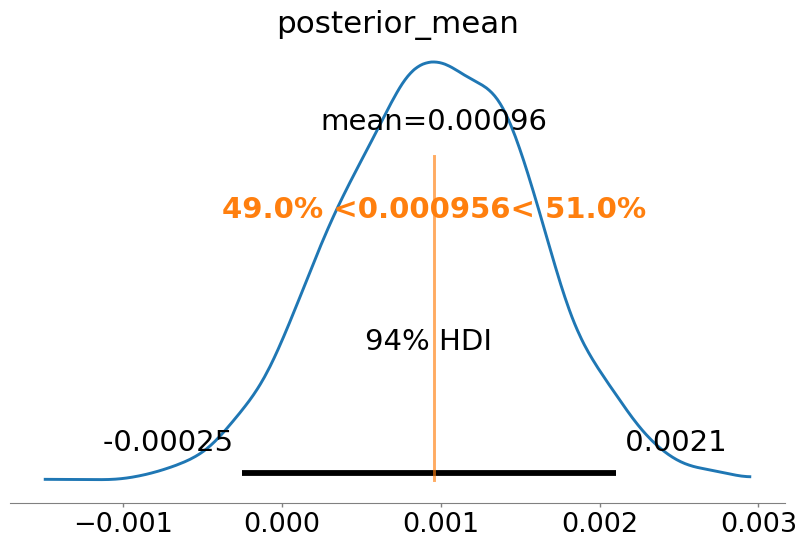

In [225]:
az.plot_posterior(idata_5ms_t, var_names=['posterior_mean'], figsize=(10,6), ref_val=0.000956,hdi_prob=0.94)
plt.plot()

In [226]:
y_pred_samples = idata_5ms_t.posterior_predictive["y"].stack(sample=("chain", "draw")).values
y_pred_mean = y_pred_samples.mean(axis=1)

rmse = np.sqrt(mean_squared_error(y_data, y_pred_mean))
print(f"RMSE: {rmse:.6f}")

RMSE: 0.127855


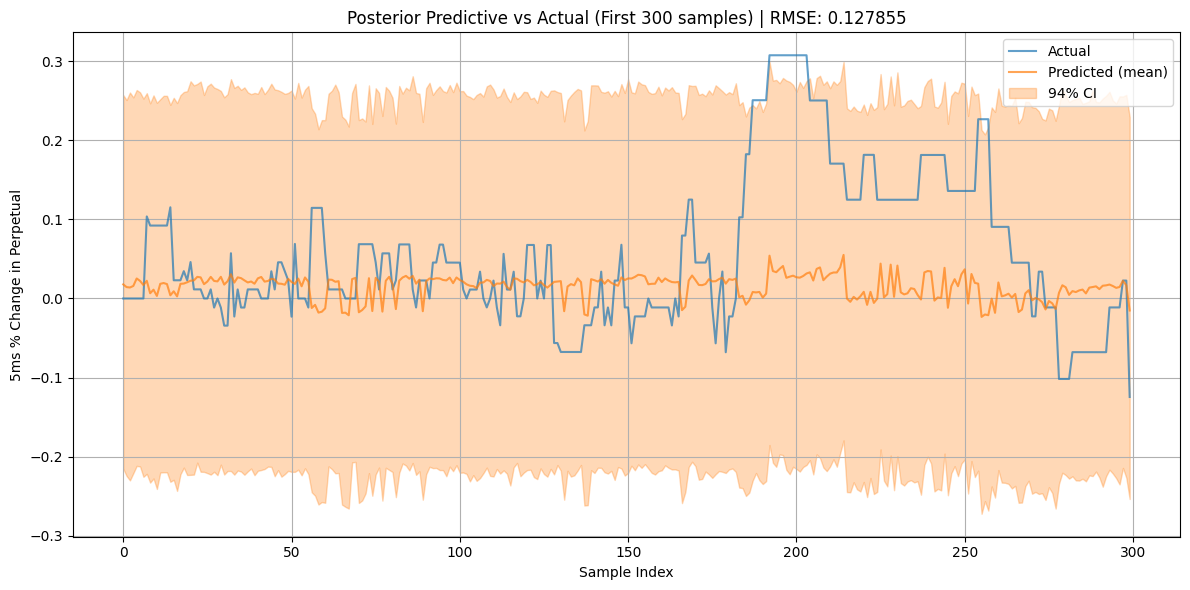

In [227]:
plt.figure(figsize=(12, 6))
plt.plot(y_data[:300], label="Actual", alpha=0.7, color="C0")
plt.plot(y_pred_mean[:300], label="Predicted (mean)", alpha=0.7, color="C1")
plt.fill_between(
    range(300),
    np.percentile(y_pred_samples[:300], 3, axis=1),
    np.percentile(y_pred_samples[:300], 97, axis=1),
    color="C1",
    alpha=0.3,
    label="94% CI"
)
plt.title(f"Posterior Predictive vs Actual (First 300 samples) | RMSE: {rmse:.6f}")
plt.xlabel("Sample Index")
plt.ylabel("5ms % Change in Perpetual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()